## Data Preprocessing 
**********
In this notebook I am will prepare the data from 'li_cleandata.csv' for modeling. This notebook will contain feature selection, feature engineering and creation of train/validate/test splits as well as explanations for how I want to use this data in my model.

#### Defining Success
- The purpose of this project is to determine if a candidate will be successful based on their features.
- To evalute success, I will use the binary 'Finalist' feature.
- Each season, 8 candidates (4 boys and 4 girls) make it to the shows finale. These 'Finalist' candidates will be our benchmark for success on the show.

Preprocessing Outline:
1. Import necessary packages/libraries
2. Import Data
3. Feature Selection
4. Feature Engineering
   - Loyalty Score
   - Region 
5. Encode Categorical Data
6. Data Splits
7. Feature Scaling (Another iteration of model perhaps - not needed for logisitc regression but possibly usefulf or decision tree)

### Import Packages
********

In [1]:
import pandas as pd
import numpy as np
import os

import sklearn.preprocessing
from sklearn.model_selection import train_test_split

### Import Data
********

In [2]:
import os
cwd = os.getcwd()

In [3]:
data = pd.read_csv(cwd + '/data/li_cleandata.csv') 

### Feature Selection 
********

There are 72 total finalists in this dataset (8 each season).

- Therefore, 72 is the historical count of 'events' that my model is attempting to predict
- I will limit myself to allowing roughly 1 variable per 15 'events' to prevent the model from becoming too complex or overfitting .
- Using this strategy, I will try to limit myself to ~5 predictive variables (72/15 = 4.8).
- I may go up to 6 or 7 total variables after some testing and tuning.

My target variable that the model will be predicting is 'Finalist'.
- Having my target variable be a binary 'Yes' or 'No' is nice for simplicity sake and allows me to capture the essence of what I believe success to be on the show, which is make it to the last day of the show.

Other target variables I could have used are:
- Status: which gives the placements, 1-4, of each finalist. I decided against using this for a few reasons. Once you are a finalist, your placement 1-4 is completely dependant onthe public, whereas  making it to the finals is a combination of contestant voting themselves, inability to form a couple, and public voting. Basically I determined that if you can endure all factors of the show to reach the finale, you are successful and gives you a chance to place first. 
- Stay: I could have equated success on the show with how long one remains in the villa, but that would not account for people who were finalists and came on the show late, so this didn't make sense.


The features that I believe to be most impactful in determining outcome of 'Finalist' are:
- Age
- Height
- Hometown and/or Region
- Entered
- OG
- Casa
- Couples

Entered, OG, and Casa are all capturing similar data. 
- I will probably decide between either just 'Entered' or use both 'OG' and 'Casa'


I will do some feature engineering below to incorporate the features above in the most efficient way possible.

### Feature Engineering
*********

#### Couples
The purpose of this feature is to determine if loyalty to one partner enhances chances of success, as opposed to coupling up with multiple partners.

Loyalty is a word constantly mentioned on the show and I wanted to quantify a contestants loyalty, so I gathered data on each contestants number unique couplings to evalute loyalty.

After analyzing this feature, I noticed some potention flaws in how this data point might be interpreted by the model.
- Some contestants will have 0 couples, making it impossible to reach the finale if their 'Couples' value is 0.
- Contestants who enter the show late and become finalists are likely to have a lower number of couples.

A way to add more context to this feature would be to divide a candidates 'Couples' by their 'Stay' in the villa. 
- This will result in providing a value that quantifies a candidates loyalty during their time on the show.

I will name this value a candidates 'Loyalty Score'.

In [4]:
#Calculate Loyalty Score
data['Loyalty'] = (data['Couples'] / data['Stay'])

In [5]:
#Check
data.head()

,Name,Season,Gender,Age,Height,Ethnicity,Hair,Eye,Hometown,Region,Entered,Dumped,Stay,OG,Casa,Status,Couples,Finalist,Loyalty
0,Malia Arkian,2,Female,26,66,MENAT,Brown,Brown,Wilmslow,England,7,7,0,No,No,Dumped,0,No,NaN
1,Ben Porter,1,Male,24,71,White,Brown,Blue,Wakefield,England,32,33,1,No,No,Dumped,0,No,0.0
2,Poppy Farnan,1,Female,22,66,White,Blonde,Blue,Cheshire,England,32,33,1,No,No,Dumped,0,No,0.0
3,Oliver Maxwell Fernandez,2,Male,25,74,White,Brown,Brown,Hertfordshire,England,30,31,1,No,No,Dumped,0,No,0.0
4,Shannon Singh,7,Female,22,68,Asian,Brown,Brown,Fife,Scotland,1,2,1,Yes,No,Dumped,1,No,1.0


Two issues with Loyalty Score:
1. Malia Arkian has a stay of zero days so I will have to replace her Loyalty value of NaN. I will replace it with '1' to indicate that she had no loyatly.
2. Candidates with 0 couples are given a loyalty score of 0. Since a lower loyalty score indicates a candidate was very loyal, I will want to change all instances of candidates with 0 couples to having a loyalty score  of 1, since they were unable to display any sort of loyalty.

In [6]:
#Contestants with 0 couples loyalty score set to 0
data.loc[data['Couples'] == 0, 'Loyalty'] = 1

In [7]:
#Check loyalty range
data['Loyalty']

0      1.000000
1      1.000000
2      1.000000
3      1.000000
4      1.000000
         ...   
290    0.052632
291    0.017241
292    0.017241
293    0.051724
294    0.034483
Name: Loyalty, Length: 295, dtype: float64

#### Regions

The purpose of this feature is to determine if candidates from a certain area perform better on the show. 
Analysis provided some insight but I want to consolidate the regions into a handful of categories to see if I can find a more informative trend.

In [8]:
#List regions included in the dataset currently
print(data['Region'].nunique())
print(data['Region'].unique())

8
['England' 'Scotland' 'Ireland' 'Wales' 'Isle of Man' 'Australia'
 'Northern Ireland' 'British Isles']


In [9]:
#Find number of total distinct hometowns in this dataset
print(data['Hometown'].nunique())

124


This dataset includes candidates from 8 unique regions and 124 unique hometowns. How will I consolidate this into one feature?
- There are 2 contestants from Australia - I will make a category called something like'NFA' which will contain any candidates not from the UK or areas around it.
- The rest of the contestants are from the same general area, how best to split that up?

The United Kingdom of Great Britain and Northern Ireland (to give its full name) refers to the political union between England, Wales, Scotland and Northern Ireland.
England is divided into 9 geographical regions. These are London, the North East, North West, Yorkshire, East Midlands, West Midlands, South East, East of England and the South West

Regions I will use:
- NFR (Not from Region - candidates from australia and any future candidates from australia or other areas like USA etc)
- Surrounding Islands (will encapsulate contestants from british isles, isle of man or any other smaller islands surrounding the main island of UK)
- Scotland
- Ireland (will include Ireland and Northern Ireland)
- Wales
- England

I got 640 prominent UK cities and their latitudes from: https://simplemaps.com/data/gb-cities
North: UK cities above 54 lat
Midlands: UK cities between 52 and 54 lat
South: UK cities below  52 lat

In [10]:
#Convert Gender and Finalist to binary values

data['Gender'] = data['Gender'].map({'Male': 1, 'Female': 0})
data['Finalist'] = data['Finalist'].map({'Yes': 1, 'No': 0})

In [11]:
#Imported latitude of 680 English cities to help seperate contestant locations into regions
eng_city_data = pd.read_csv(cwd + '/data/english_city_data.csv')
eng_city_data.shape

(680, 2)

In [12]:
#check new dataframe
eng_city_data.head()

,city,lat
0,London,51.5072
1,Birmingham,52.4800
2,Manchester,53.4794
3,Liverpool,53.4075
4,Portsmouth,50.8058


In [13]:
#split cities into regions by latitude
eng_north = eng_city_data[eng_city_data['lat']>= 54]
eng_mid = eng_city_data[eng_city_data['lat'].between(52,  54)]
eng_south = eng_city_data[eng_city_data['lat']<= 52]

In [14]:
#turn the above into lists
north = eng_north['city'].tolist()
midlands = eng_mid['city'].tolist()
south = eng_south['city'].tolist()

In [15]:
#Create an empty column for location
data = data.assign(Location=" ")
data.head()

,Name,Season,Gender,Age,Height,Ethnicity,Hair,Eye,Hometown,Region,Entered,Dumped,Stay,OG,Casa,Status,Couples,Finalist,Loyalty,Location
0,Malia Arkian,2,0,26,66,MENAT,Brown,Brown,Wilmslow,England,7,7,0,No,No,Dumped,0,0,1.0,
1,Ben Porter,1,1,24,71,White,Brown,Blue,Wakefield,England,32,33,1,No,No,Dumped,0,0,1.0,
2,Poppy Farnan,1,0,22,66,White,Blonde,Blue,Cheshire,England,32,33,1,No,No,Dumped,0,0,1.0,
3,Oliver Maxwell Fernandez,2,1,25,74,White,Brown,Brown,Hertfordshire,England,30,31,1,No,No,Dumped,0,0,1.0,
4,Shannon Singh,7,0,22,68,Asian,Brown,Brown,Fife,Scotland,1,2,1,Yes,No,Dumped,1,0,1.0,


In [16]:
#If region is not england, I will copy that value to the Location column
data['Location'] = np.where(~data['Region'].isin(['England']), data['Region'], data['Location'])

In [17]:
#If region IS england, I will copy the value of 'Hometown' to the 'Location' column
data['Location'] = np.where(data['Region'].isin(['England']), data['Hometown'], data['Location'])

In [18]:
data.head()

,Name,Season,Gender,Age,Height,Ethnicity,Hair,Eye,Hometown,Region,Entered,Dumped,Stay,OG,Casa,Status,Couples,Finalist,Loyalty,Location
0,Malia Arkian,2,0,26,66,MENAT,Brown,Brown,Wilmslow,England,7,7,0,No,No,Dumped,0,0,1.0,Wilmslow
1,Ben Porter,1,1,24,71,White,Brown,Blue,Wakefield,England,32,33,1,No,No,Dumped,0,0,1.0,Wakefield
2,Poppy Farnan,1,0,22,66,White,Blonde,Blue,Cheshire,England,32,33,1,No,No,Dumped,0,0,1.0,Cheshire
3,Oliver Maxwell Fernandez,2,1,25,74,White,Brown,Brown,Hertfordshire,England,30,31,1,No,No,Dumped,0,0,1.0,Hertfordshire
4,Shannon Singh,7,0,22,68,Asian,Brown,Brown,Fife,Scotland,1,2,1,Yes,No,Dumped,1,0,1.0,Scotland


In [19]:
#Create a dict to map possible values to keys
location_map = {
    'North' : north,
    'Midlands' : midlands,
    'South' : south,
    'Wales' : ['Wales'],
    'Scotland' : ['Scotland'],
    'Ireland' : ['Northern Ireland', 'Ireland'],
    'Islands' : ['Isle of Man', 'British Isles'],
    'NFR' : ['Australia']
}

In [20]:
#Invert the map for easier use
invert_map = {}
for key, value  in location_map.items():
    for v in value:
        invert_map.setdefault(v, []).append(key)

In [21]:
#Apply the mapping 
data['Final_Location'] = data['Location'].map(invert_map)

In [22]:
# Check where mapping didn't work 
# 135 rows received a Nan value
data_locay_chk = data[data['Final_Location'].isnull()]
data_locay_chk

,Name,Season,Gender,Age,Height,Ethnicity,Hair,Eye,Hometown,Region,...,Dumped,Stay,OG,Casa,Status,Couples,Finalist,Loyalty,Location,Final_Location
0,Malia Arkian,2,0,26,66,MENAT,Brown,Brown,Wilmslow,England,...,7,0,No,No,Dumped,0,0,1.000000,Wilmslow,NaN
1,Ben Porter,1,1,24,71,White,Brown,Blue,Wakefield,England,...,33,1,No,No,Dumped,0,0,1.000000,Wakefield,NaN
2,Poppy Farnan,1,0,22,66,White,Blonde,Blue,Cheshire,England,...,33,1,No,No,Dumped,0,0,1.000000,Cheshire,NaN
3,Oliver Maxwell Fernandez,2,1,25,74,White,Brown,Brown,Hertfordshire,England,...,31,1,No,No,Dumped,0,0,1.000000,Hertfordshire,NaN
5,James Khan,2,1,20,75,White,Brown,Blue,Teddington,England,...,20,2,No,No,Dumped,0,0,1.000000,Teddington,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,Ron Hall,9,1,25,73,White,Brown,Green,Essex,England,...,58,57,Yes,No,2,3,1,0.052632,Essex,NaN
290,Tom Clare,9,1,23,77,White,Brown,Blue,Barnsley,England,...,58,57,Yes,No,3,3,1,0.052632,Barnsley,NaN
291,Dani Dyer,4,0,21,61,White,Brown,Green,East London,England,...,59,58,Yes,No,1,1,1,0.017241,East London,NaN
292,Jack Fincham,4,1,26,70,White,Brown,Blue,Kent,England,...,59,58,Yes,No,1,1,1,0.017241,Kent,NaN


In [23]:
#Find the amount of unique values that were not mapped
#Print the names of those values

print(data_locay_chk.Location.nunique())
print(data_locay_chk.Location.unique())

#59 unique values were not mapped properly
#I will add the 59 values below to my dataset and reupdate locations

59
['Wilmslow' 'Wakefield' 'Cheshire' 'Hertfordshire' 'Teddington' 'Brighton'
 'Wiltshire' 'Essex' 'Surrey' 'Yarm' 'Cornwall' 'Pett' 'North London'
 'Kingston' 'Sheffield' 'Cheltenham' 'Barnsley' 'Newcastle' 'Swindon'
 'Ipswich' 'York' 'Cotswolds' 'Wigan' 'Leeds' 'Kent' 'Derbyshire'
 'Preston' 'Bromley' 'Hampshire' 'Doncaster' 'Cockfosters' 'Devon'
 'The Wirral' 'Buckinghamshire' 'Exeter' 'Reading' 'South East London'
 'Northumberland' 'Chelsea' 'Battersea' 'Kingston upon Hull'
 'Warwickshire' 'Suffolk' 'East London' 'Hull' 'Middlesbrough' 'Bedford'
 'Milton Keynes' 'Huddersfield' 'Cumbria' 'Redcar' 'South London' 'Tring'
 'Worthing' 'Bolton' 'Guildford' 'Shropshire' 'Thrisk' 'Staffordshire']


In [24]:
#Checked latitudes of above list and categorized them into North/Midlands/South
# 19 in north
# 13 in mid
# 27 in south

north_additions = ['Wakefield', 'Newcastle', 'Sheffield', 'Barnsley', 'York', 'Wigan', 'Leeds', 'Derbyshire', 'Preston', 'Doncaster', 'Northumberland', 'Kingston upon Hull', 'Hull', 'Middlesbrough', 'Bedford', 'Huddersfield', 'Redcar', 'Bolton', 'Cumbria']
midlands_additions = ['Wilmslow', 'Teddington', 'Cheltenham', 'Swindon', 'Ipswich', 'Cotswolds', 'Bromley', 'Reading', 'Chelsea', 'Battersea', 'Warwickshire', 'Thrisk', 'Milton Keynes']
south_additions = ['Cheshire', 'Hertfordshire', 'Brighton', 'Wiltshire', 'Essex', 'Surrey', 'Yarm', 'Cornwall', 'Pett', 'North London', 'Kingston', 'Hampshire', 'Cockfosters', 'Devon', 'The Wirral', 'Buckinghamshire', 'Exeter', 'South East London', 'Suffolk', 'South London', 'Worthing', 'East London', 'Guildford', 'Shropshire', 'Staffordshire', 'Kent', 'Tring']

In [25]:
# add the above to north/midlands/south variables by using the .extend() method
north2 = north + north_additions
midlands2 = midlands + midlands_additions
south2 = south + south_additions

In [26]:
data = data.assign(Location=" ", Final_Location=" ")
data.head()

,Name,Season,Gender,Age,Height,Ethnicity,Hair,Eye,Hometown,Region,...,Dumped,Stay,OG,Casa,Status,Couples,Finalist,Loyalty,Location,Final_Location
0,Malia Arkian,2,0,26,66,MENAT,Brown,Brown,Wilmslow,England,...,7,0,No,No,Dumped,0,0,1.0,,
1,Ben Porter,1,1,24,71,White,Brown,Blue,Wakefield,England,...,33,1,No,No,Dumped,0,0,1.0,,
2,Poppy Farnan,1,0,22,66,White,Blonde,Blue,Cheshire,England,...,33,1,No,No,Dumped,0,0,1.0,,
3,Oliver Maxwell Fernandez,2,1,25,74,White,Brown,Brown,Hertfordshire,England,...,31,1,No,No,Dumped,0,0,1.0,,
4,Shannon Singh,7,0,22,68,Asian,Brown,Brown,Fife,Scotland,...,2,1,Yes,No,Dumped,1,0,1.0,,


In [27]:
#If region is not england, I will copy that value to the Location column
data['Location'] = np.where(~data['Region'].isin(['England']), data['Region'], data['Location'])

In [28]:
#If region IS england, I will copy the value of 'Hometown' to the 'Location' column
data['Location'] = np.where(data['Region'].isin(['England']), data['Hometown'], data['Location'])

In [29]:
#Create a dict to map possible values to keys
location_map2 = {
    'North' : north2,
    'Midlands' : midlands2,
    'South' : south2,
    'Wales' : ['Wales'],
    'Scotland' : ['Scotland'],
    'Ireland' : ['Northern Ireland', 'Ireland'],
    'Islands' : ['Isle of Man', 'British Isles'],
    'NFR' : ['Australia']
}

In [30]:
#Invert the map for easier use
invert_map2 = {}
for key, value in location_map2.items():
    for v in value:
        invert_map2.setdefault(v, []).append(key)

In [31]:
#Apply the mapping 
data['Final_Location2'] = data['Location'].map(invert_map2)

In [32]:
# Check where mapping didn't work 
# 135 rows received a Nan value
data_local_chk2 = data[data['Final_Location2'].isnull()]
data_local_chk2

,Name,Season,Gender,Age,Height,Ethnicity,Hair,Eye,Hometown,Region,...,Stay,OG,Casa,Status,Couples,Finalist,Loyalty,Location,Final_Location,Final_Location2


In [33]:
data.head(5)

,Name,Season,Gender,Age,Height,Ethnicity,Hair,Eye,Hometown,Region,...,Stay,OG,Casa,Status,Couples,Finalist,Loyalty,Location,Final_Location,Final_Location2
0,Malia Arkian,2,0,26,66,MENAT,Brown,Brown,Wilmslow,England,...,0,No,No,Dumped,0,0,1.0,Wilmslow,,[Midlands]
1,Ben Porter,1,1,24,71,White,Brown,Blue,Wakefield,England,...,1,No,No,Dumped,0,0,1.0,Wakefield,,[North]
2,Poppy Farnan,1,0,22,66,White,Blonde,Blue,Cheshire,England,...,1,No,No,Dumped,0,0,1.0,Cheshire,,[South]
3,Oliver Maxwell Fernandez,2,1,25,74,White,Brown,Brown,Hertfordshire,England,...,1,No,No,Dumped,0,0,1.0,Hertfordshire,,[South]
4,Shannon Singh,7,0,22,68,Asian,Brown,Brown,Fife,Scotland,...,1,Yes,No,Dumped,1,0,1.0,Scotland,,[Scotland]


In [34]:
#The values were saved as lists with 1 value, so I indexed to the first location and set the column value equal to the first(and only) string in the list
#This effectively removes the brackets
data['Final_Location2'] =  data['Final_Location2'].str[0]

In [35]:
data.head(5)

,Name,Season,Gender,Age,Height,Ethnicity,Hair,Eye,Hometown,Region,...,Stay,OG,Casa,Status,Couples,Finalist,Loyalty,Location,Final_Location,Final_Location2
0,Malia Arkian,2,0,26,66,MENAT,Brown,Brown,Wilmslow,England,...,0,No,No,Dumped,0,0,1.0,Wilmslow,,Midlands
1,Ben Porter,1,1,24,71,White,Brown,Blue,Wakefield,England,...,1,No,No,Dumped,0,0,1.0,Wakefield,,North
2,Poppy Farnan,1,0,22,66,White,Blonde,Blue,Cheshire,England,...,1,No,No,Dumped,0,0,1.0,Cheshire,,South
3,Oliver Maxwell Fernandez,2,1,25,74,White,Brown,Brown,Hertfordshire,England,...,1,No,No,Dumped,0,0,1.0,Hertfordshire,,South
4,Shannon Singh,7,0,22,68,Asian,Brown,Brown,Fife,Scotland,...,1,Yes,No,Dumped,1,0,1.0,Scotland,,Scotland


### EVERY LOCATION IS ACCOUNTED FOR!!!!
8 categories for a contestants location

- Original dataset contains 680 cities/towns
- Manually added 59 counties
- This gives me a range of 739 possible values that I can receive via love island wiki and programatically map.
- Was tedious work up front but I should be set up to add new contestants and have them categorized by region without any further manual work. 
- I can add any cities/counties I missed as they arise but hopefully with 739 mapped values, I am covered from having to do that.

### Analysis of New Features
*********

I need to analyze loyalty score and location

In [36]:
#Import package for quick analysis
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
# Set up some dataframes for quick analysis

#split data by Finalists to analyze new features
finalists = data[data['Finalist'] == 'Yes']
non_finalists = data[data['Finalist'] == 'No']

# Split data by values in Status as well
first = data[data['Status'] == '1']
second = data[data['Status'] == '2']
third = data[data['Status'] == '3']
fourth = data[data['Status'] == '4']
dumped = data[data['Status'] == 'Dumped']

In [38]:
#Average loyalty score for each 'Status' value
print('1st Place Contestants Loyalty Score: ' + str(round(first['Loyalty'].mean(), 4)))
print('2nd Place Contestants Loyalty Score: ' + str(round(second['Loyalty'].mean(), 4)))
print('3rd Place Contestants Loyalty Score: ' + str(round(third['Loyalty'].mean(), 4)))
print('4th Place Contestants Loyalty Score: ' + str(round(fourth['Loyalty'].mean(), 4)))
print('Dumped Contestants Loyalty Score: ' + str(round(dumped['Loyalty'].mean(), 4)))

1st Place Contestants Loyalty Score: 0.0494
2nd Place Contestants Loyalty Score: 0.0524
3rd Place Contestants Loyalty Score: 0.0583
4th Place Contestants Loyalty Score: 0.0645
Dumped Contestants Loyalty Score: 0.3795


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

<Axes: xlabel='Gender', ylabel='Loyalty'>

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3544: UserWarning: 20.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3544: UserWarning: 15.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


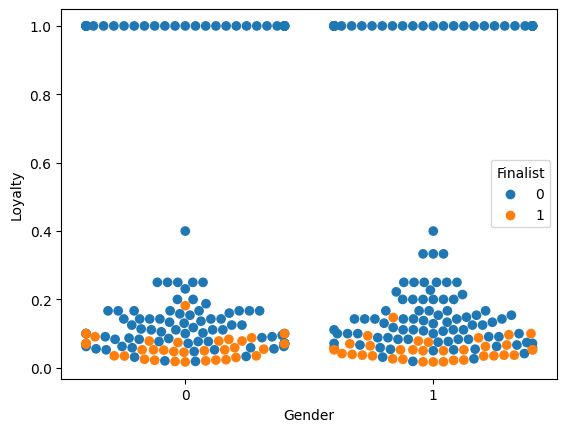

In [39]:
sns.swarmplot(data=data, x="Gender", y="Loyalty", hue="Finalist", size=7)

Islanders given a 1 automatically  doesn't seem like the best way to represent their loyalty. Can I scale this data another way?
- I will probably give islanders with 0 couples a normalized value (median or mean?) so the scaling wont  be  so harsh

([], [])

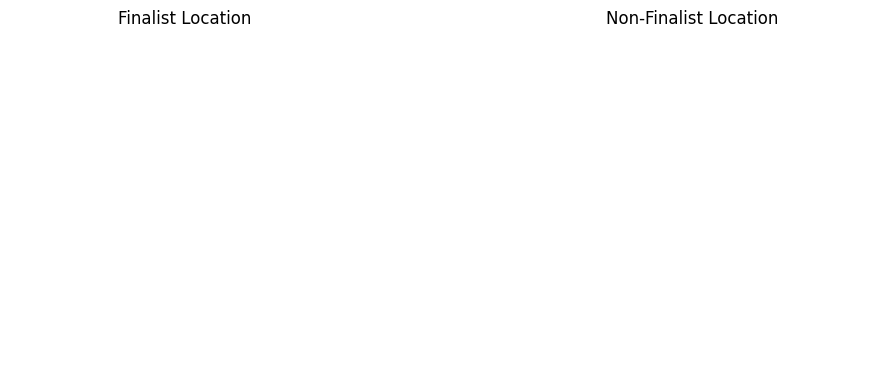

In [40]:
#Location of finalists vs non finalists
finalist_location = finalists['Final_Location2'].value_counts()
non_finalist_location = non_finalists['Final_Location2'].value_counts()

colors = ['cyan', 'orchid', 'lightgreen', 'yellow', 'salmon', 'navy', 'orange', 'silver']

fig = plt.figure(figsize=(12,10))

ax1 = fig.add_subplot(221)
ax1.set_title('Finalist Location')
ax1.pie(finalist_location, labels=finalist_location.index, colors = colors)

ax2 = fig.add_subplot(222)
ax2.set_title('Non-Finalist Location')
ax2.pie(non_finalist_location, labels=non_finalist_location.index, colors = colors)

### Encoding
*********

In [41]:
#Creating dummy columns for location

location_dummies = pd.get_dummies(data['Final_Location2'])
location_dummies.head()

,Ireland,Islands,Midlands,NFR,North,Scotland,South,Wales
0,False,False,True,False,False,False,False,False
1,False,False,False,False,True,False,False,False
2,False,False,False,False,False,False,True,False
3,False,False,False,False,False,False,True,False
4,False,False,False,False,False,True,False,False


In [42]:
#concat newly created columns with original dataframe
data = pd.concat([data, location_dummies],axis=1)

#Drop location column now
# data = data.drop(columns=['Final_Location2'])
# data.head(3)

In [43]:
data.head()

,Name,Season,Gender,Age,Height,Ethnicity,Hair,Eye,Hometown,Region,...,Final_Location,Final_Location2,Ireland,Islands,Midlands,NFR,North,Scotland,South,Wales
0,Malia Arkian,2,0,26,66,MENAT,Brown,Brown,Wilmslow,England,...,,Midlands,False,False,True,False,False,False,False,False
1,Ben Porter,1,1,24,71,White,Brown,Blue,Wakefield,England,...,,North,False,False,False,False,True,False,False,False
2,Poppy Farnan,1,0,22,66,White,Blonde,Blue,Cheshire,England,...,,South,False,False,False,False,False,False,True,False
3,Oliver Maxwell Fernandez,2,1,25,74,White,Brown,Brown,Hertfordshire,England,...,,South,False,False,False,False,False,False,True,False
4,Shannon Singh,7,0,22,68,Asian,Brown,Brown,Fife,Scotland,...,,Scotland,False,False,False,False,False,True,False,False


In [44]:
#Drop columns i dont need
column_drops = ['Ethnicity', 'Hair', 'Eye',	'Hometown',	'Region', 'Stay', 'Dumped', 'OG', 'Casa', 'Status', 'Couples', 'Location', 'Final_Location', 'Final_Location2']
model_data = data.drop(columns=column_drops)
model_data.head()

,Name,Season,Gender,Age,Height,Entered,Finalist,Loyalty,Ireland,Islands,Midlands,NFR,North,Scotland,South,Wales
0,Malia Arkian,2,0,26,66,7,0,1.0,False,False,True,False,False,False,False,False
1,Ben Porter,1,1,24,71,32,0,1.0,False,False,False,False,True,False,False,False
2,Poppy Farnan,1,0,22,66,32,0,1.0,False,False,False,False,False,False,True,False
3,Oliver Maxwell Fernandez,2,1,25,74,30,0,1.0,False,False,False,False,False,False,True,False
4,Shannon Singh,7,0,22,68,1,0,1.0,False,False,False,False,False,True,False,False


In [45]:
#Send this model to a csv file to pull into modeling later
model_data.to_csv(cwd + '/data/model_data.csv', index=False)

Text(0.5, 1.0, 'Feature Correlation with Finalist')

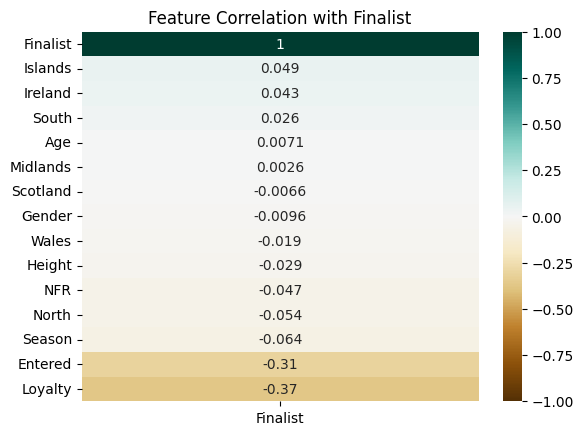

In [46]:
model_data_noname = model_data.drop(columns='Name')
heatmap = sns.heatmap(model_data_noname.corr()
                      [['Finalist']].sort_values(by='Finalist', ascending=False), vmin=-1,
                       vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Feature Correlation with Finalist')

Loyalty and Entered are negatively correlated with being a finalist.
- The earlier you enter, and the lower your loyalty score(more loyal) gives a higher chance of reaching the finale.

I know from analyis that height and age should be more expressive than shown here.

Based on what I see here, a regression model may not perform as well as other types of models (ie decision tree)

### Split Dataset

splits: train/validate/test
How to split? by Season?
Train: 1-7: n-224 or ~76%
Validate:8: n-36 or ~12%
Test:9: n-35 or ~ 12%
This split makes sense to me, since the model in practice will only be predicting finalists from one season (the current season), so it makes sense to train it on roughly 80% of available data, and then validate and test on single seasons so guage performance
Then it is decided: model will be trained on data from Seasons 1 through 7
                    Model performance will be validated on season 8 so I can tune paramaters based off of that
                    Finally, I will test model using season 9 data
                    Once season 10 has finished, I may remodel  and  add season 9 to validation set and use 10 as the test - At that point, I can also begin using the model to predict season 11 before results are known

https://builtin.com/data-science/train-test-split 

good refernce above for this. shows how to do split AND how to import model of choice from scikit learn

In [47]:
#Train, validate, test splits
def train_val_test(data, label):
    #Split data into train,validate,test splits by season

    # features = ['Name', 'Age', 'other features']
    # x =  train.loc[:, features]
    # y = train.loc[:, ['Finalist']]

    train = data[data['Season'] <= 7]
    validate = data[data['Season'] == 8]
    test = data[data['Season'] == 9]

    x_train = train.drop(columns=[label])
    y_train = train[label]

    x_validate = validate.drop(columns=[label])
    y_validate = validate[label]

    x_test = test.drop(columns=[label])
    y_test = test[label]

    print('Train Split: ', x_train.shape, '| Validate Split: ', x_validate.shape, '| Test Split: ', x_test.shape)

    return x_train, y_train, x_validate, y_validate, x_test, y_test

In [48]:
x_train, y_train, x_validate, y_validate, x_test, y_test = train_val_test(model_data, 'Finalist')

Train Split:  (224, 15) | Validate Split:  (36, 15) | Test Split:  (35, 15)


In [49]:
x_train.head()

,Name,Season,Gender,Age,Height,Entered,Loyalty,Ireland,Islands,Midlands,NFR,North,Scotland,South,Wales
0,Malia Arkian,2,0,26,66,7,1.0,False,False,True,False,False,False,False,False
1,Ben Porter,1,1,24,71,32,1.0,False,False,False,False,True,False,False,False
2,Poppy Farnan,1,0,22,66,32,1.0,False,False,False,False,False,False,True,False
3,Oliver Maxwell Fernandez,2,1,25,74,30,1.0,False,False,False,False,False,False,True,False
4,Shannon Singh,7,0,22,68,1,1.0,False,False,False,False,False,True,False,False


In [50]:
y_train.head()

0    0
1    0
2    0
3    0
4    0
Name: Finalist, dtype: int64

### Data Scaling
********

Will likely leave for  another iteration

- Will not scale, but  rather might normalize values for loyalty score